In [1]:
'''
Técnicas Envolvidas
• Análise descritiva de dados.
• Classificação binária.
• Clustering.
Desafios
Para esse projeto, alguns desafios são:
• Classificação conforme like/dislike vinculado aos comentários, extrapolar like/dislike de quem comentou e não
classificou.
• Clustering baseado em comentários.
• Análise de mudança de sentimento no decorrer do tempo.
'''

'\nTécnicas Envolvidas\n• Análise descritiva de dados.\n• Classificação binária.\n• Clustering.\nDesafios\nPara esse projeto, alguns desafios são:\n• Classificação conforme like/dislike vinculado aos comentários, extrapolar like/dislike de quem comentou e não\nclassificou.\n• Clustering baseado em comentários.\n• Análise de mudança de sentimento no decorrer do tempo.\n'

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import operator
import json
import matplotlib.pyplot as plt
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
import re
from keras.callbacks import *
from keras.layers import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from nltk.corpus import stopwords

Using TensorFlow backend.


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

In [4]:
def mlp_model(hidden_units, classes, top_words, embedding_size, max_len):
    
    model = Sequential(name = 'seq_1')
    model.add(Embedding(top_words, embedding_size, input_length=max_len, name = 'emb_1'))
    model.add(Flatten(name = 'fla_1'))
    model.add(Dense(hidden_units, activation='relu', name = 'den_1'))
    
    if classes > 1:
        model.add(Dense(classes - 1, activation='softmax', name = 'den_2n'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid', name = 'den_21'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [5]:
def cnn_model(filters, kernel_size, hidden_units, classes, top_words, embedding_size, max_len):
    
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_len))
    model.add(Conv1D(filters, kernel_size, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hidden_units, activation='relu'))
    
    if classes > 1:
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [6]:
def lstm_model(lstm_units, classes, top_words, embedding_size, max_len):
    
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(Dropout(0.2))
    
    if classes > 1:
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
UScomments = pd.read_csv('data/UScomments.csv', error_bad_lines = False)

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
C:\Users\fbrolesi\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
UScommentTest = UScomments.head(50000)

In [9]:
UScommentTest.head()

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [10]:
%%time
# TODO: se o arquivo "polarity.csv" exisit, então carrega o arquivo
pol = [] # list which will contain the polarity of the comments
for i in UScommentTest.comment_text.values:
    try:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    except:
        pol.append(0)

Wall time: 31.8 s


In [11]:
pol_ranges = [int(x) for x in pol] # [int(x) / 2 for x in [y * 2 for y in pol]]

In [12]:
UScommentTest['sentiment'] = pol_ranges

C:\Users\fbrolesi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
UScommentTest.head()

,video_id,comment_text,likes,replies,sentiment
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,0
4,XpVt6Z1Gjjo,trending 😉,3,0,0


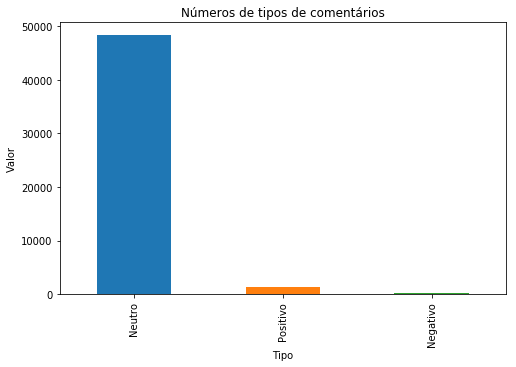

In [14]:
UScommentTest['sentiment'].replace({1:'Positivo', 0:'Neutro', -1:'Negativo'}).value_counts().plot(kind='bar',figsize=(8,5));
plt.title('Números de tipos de comentários');
plt.xlabel('Tipo');
plt.ylabel('Valor');

In [15]:
%%time
UScommentTest = UScommentTest[UScommentTest.sentiment != 0]
UScommentTest['text'] = UScommentTest['comment_text'].apply(lambda x: x.lower())
UScommentTest['text'] = UScommentTest['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
UScommentTest['text'] = UScommentTest['text'].apply((lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")])))

Wall time: 11.2 s


In [38]:
UScommentTest.to_csv('UScommentTest.csv')

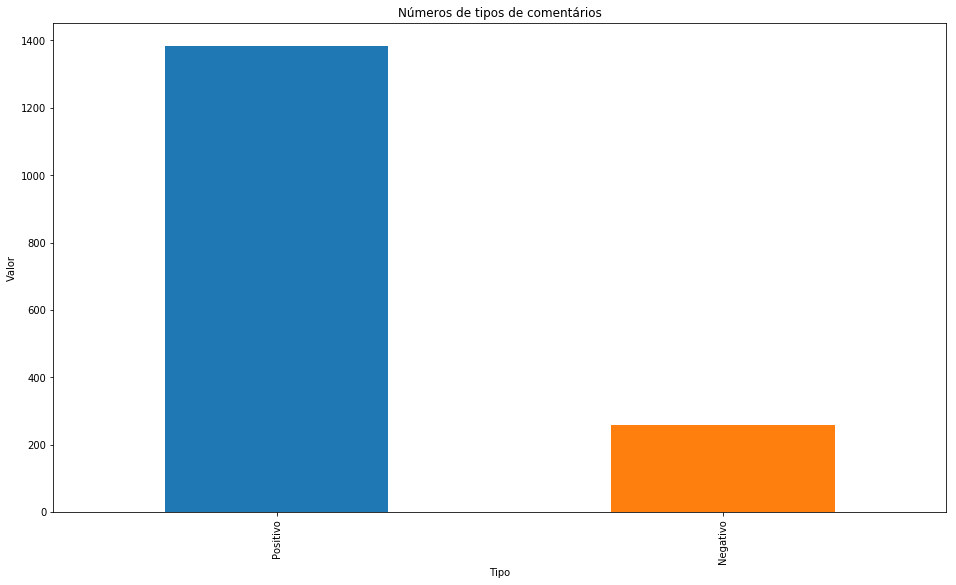

In [16]:
UScommentTest['sentiment'].replace({1:'Positivo', -1:'Negativo'}).value_counts().plot(kind='bar',figsize=(16,9));
plt.title('Números de tipos de comentários');
plt.xlabel('Tipo');
plt.ylabel('Valor');

In [17]:
UScommentTest.head()

,video_id,comment_text,likes,replies,sentiment,text
64,XpVt6Z1Gjjo,yu are the best,1,0,1,yu best
156,cLdxuaxaQwc,Power is the disease. Care is the cure. Keep...,0,0,1,power disease care cure keep caring others bes...
227,WYYvHb03Eog,YAS Can't wait to get it! I just need to sell ...,0,0,1,yas cant wait get need sell kidney afford ipho...
307,sjlHnJvXdQs,This is priceless,0,0,1,priceless
319,sjlHnJvXdQs,Summed up perfectly,0,0,1,summed perfectly


In [18]:
word_freq = Counter() 
for item in UScommentTest.text:
    for word in item.split():
        if not word in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

In [19]:
top_words = 1000
word_to_id = {}
if top_words:
    top = top_words
    most_common_words = word_freq.most_common(top_words)

    for i in range(top_words):
        word_to_id[most_common_words[i][0]] = top
        top -= 1
else:
    top = len(word_freq)
    most_common_words = word_freq.most_common()

    for i in range(len(word_freq)):
        word_to_id[most_common_words[i][0]] = top
        top -= 1

# np.save("word_to_id.npy", word_to_id)

In [20]:
pad_len = 32
max_len = 0

X_data = []
for current_text in UScommentTest.text:
    if len(current_text.split()) > max_len:
        max_len = len(current_text.split())

    aux = []
    for word in current_text.split():
        if not word in word_to_id:
            aux.append(0)
        else:
            aux.append(word_to_id[word])

    X_data.append(aux)

padding_size = 0
if pad_len:
    padding_size = pad_len
else:
    padding_size = max_len

X, y = pad_sequences(X_data, padding_size, padding='post'), to_categorical((UScommentTest.sentiment + 1) / 2)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1034, 32) (1034, 2)
(493, 32) (493, 2)
(115, 32) (115, 2)


# MLP

In [32]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta = 1e-6, 
                           patience = 2, 
                           verbose = 2, 
                           mode='auto', 
                           baseline=None)

In [33]:
classes = y.shape[1]
embedding_size = 32

In [34]:
model = mlp_model(250, classes + 1, top_words + 1, embedding_size, max_len)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb_1 (Embedding)            (None, 32, 32)            32032     
_________________________________________________________________
fla_1 (Flatten)              (None, 1024)              0         
_________________________________________________________________
den_1 (Dense)                (None, 250)               256250    
_________________________________________________________________
den_2n (Dense)               (None, 2)                 502       
Total params: 288,784
Trainable params: 288,784
Non-trainable params: 0
_________________________________________________________________


In [35]:
y_train_compact = y_train.copy()
y_train_compact = pd.DataFrame(y_train_compact)
y_train_compact = y_train_compact[1] #.map({0: -1, 1: 1})
balancer = SMOTE()
x_resampled, y_resampled = balancer.fit_sample(X_train, y_train_compact)
y_resampled = to_categorical(y_resampled)

In [36]:
training_history = []
training_history.append(model.fit(x_resampled, y_resampled, epochs = 10, validation_data = [X_val, y_val], callbacks = [early_stop]))
print("================================================================================")
result = model.evaluate(X_test, y_test)

print('Accuracy (test set): {}'.format(result[1]))

Train on 1722 samples, validate on 115 samples
Epoch 1/10
1722/1722 [==============================] - 1s 451us/step - loss: 0.6351 - acc: 0.6510 - val_loss: 0.5973 - val_acc: 0.6435
Epoch 2/10
1722/1722 [==============================] - 0s 260us/step - loss: 0.3219 - acc: 0.8722 - val_loss: 0.3261 - val_acc: 0.8609
Epoch 3/10
1722/1722 [==============================] - 0s 258us/step - loss: 0.1339 - acc: 0.9501 - val_loss: 0.3806 - val_acc: 0.8609
Epoch 4/10
1722/1722 [==============================] - 0s 262us/step - loss: 0.0735 - acc: 0.9739 - val_loss: 0.4325 - val_acc: 0.8696
Epoch 00004: early stopping


ValueError: Error when checking target: expected den_2n to have shape (2,) but got array with shape (1,)

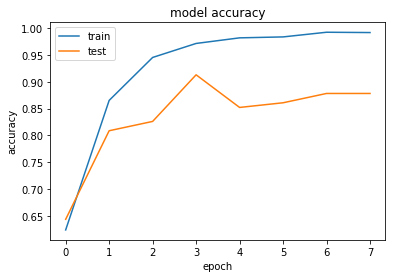

In [28]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
y_pred = model.predict(X_test)

y_test = np.argmax(y_test, axis = 1)
y_pred = np.argmax(y_pred, axis = 1)

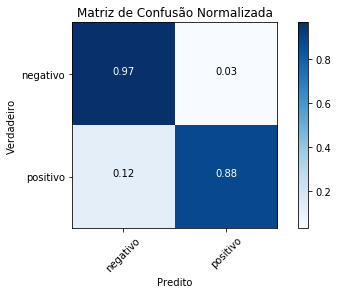

In [30]:
class_names = ['negativo', 'positivo']

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matriz de Confusão Normalizada')

plt.show()